# Content-based Recommendation On Steam Games

## Imports
---

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# import stemmer from sklearn
from nltk.stem import PorterStemmer
from ast import literal_eval

# import one-hot encoder 
from sklearn.preprocessing import MultiLabelBinarizer

# Function to reduce the memory usage of a DataFrame.
def reduce_memory(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

# Generator function to load data in chunks.
def data_generator(df, chunksize=10000):
    for i in range(0, df.shape[0], chunksize):
        yield df.iloc[i:i+chunksize]

# Load data
games_df = reduce_memory(pd.read_csv('./data/games.csv'))
users_df = reduce_memory(pd.read_csv('./data/users.csv'))
recommendations_df = reduce_memory(pd.read_csv('./data/recommendations.csv'))

In [30]:
games_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True


In [31]:
users_df.head()

,user_id,products,reviews
0,7360263,359,0
1,14020781,156,1
2,8762579,329,4
3,4820647,176,4
4,5167327,98,2


In [32]:
recommendations_df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.299999,51580,0
1,304390,4,0,2017-02-17,False,11.500000,2586,1
2,1085660,2,0,2019-11-17,True,336.500000,253880,2
3,703080,0,0,2022-09-23,True,27.400000,259432,3
4,526870,0,0,2021-01-10,True,7.900000,23869,4


## Data visualization
---

### Shape, Features, and Null values:

#### Games Dataset

Feature Descriptions:
_______________________
- app_id = product ID on steam
- title = product title
- date_release = product release date
- win = supports Windows?
- mac = support MacOS?
- linux = supports Linux?
- rating = product rating category
- positive_ratio = ratio of positive feedbacks
- user_reviews = amount of user reviews available on the Steam page
- price_final = price in US dollars calculated after discount
- steam_deck = available on Steam Deck?

In [33]:
print("Games Dataset:")
print("Rows and columns:", games_df.shape)
print("Features:", games_df.columns.tolist())
print("Null values:\n", games_df.isnull().sum())

Games Dataset:
Rows and columns: (50872, 13)
Features: ['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck']
Null values:
 app_id            0
title             0
date_release      0
win               0
mac               0
linux             0
rating            0
positive_ratio    0
user_reviews      0
price_final       0
price_original    0
discount          0
steam_deck        0
dtype: int64


#### Users Dataset

Feature Descriptions:
_______________________
- user_id = user's auto-generated ID
- products = number of games/add-ons purchased by the user
- reviews = number of reviews the user has published

In [34]:
print("Users Dataset:")
print("Rows and columns:", users_df.shape)
print("Features:", users_df.columns.tolist())
print("Null values:\n", users_df.isnull().sum())

Users Dataset:
Rows and columns: (14306064, 3)
Features: ['user_id', 'products', 'reviews']
Null values:
 user_id     0
products    0
reviews     0
dtype: int64


#### Recommendations Dataset

In [35]:
print("Recommendations Dataset:")
print("Rows and columns:", recommendations_df.shape)
print("Features:", recommendations_df.columns.tolist())
print("Null values:\n", recommendations_df.isnull().sum())

Recommendations Dataset:
Rows and columns: (41154794, 8)
Features: ['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours', 'user_id', 'review_id']
Null values:
 app_id            0
helpful           0
funny             0
date              0
is_recommended    0
hours             0
user_id           0
review_id         0
dtype: int64


Feature Descriptions:
_______________________
- app_id = product ID on Steam
- helpful = how many users found a recommendation helpful
- funny = how many users found a recommendation funny
- date = date of publishing
- is_recommended = is the user recommending the product?
- hours = how many hours played by the user
- user_id = user's anonymized ID
- review_id =  autogenerated ID

### Understanding the Dataset:

#### Games Dataset

In [36]:
games_df.dtypes

app_id              int32
title              object
date_release       object
win                  bool
mac                  bool
linux                bool
rating             object
positive_ratio      int32
user_reviews        int32
price_final       float32
price_original    float32
discount          float32
steam_deck           bool
dtype: object

In [37]:
for col in games_df.columns:
    print(f"Feature: {col}")
    print(games_df[col].unique()[:5])
    print("-" * 40)

Feature: app_id
[ 13500  22364 113020 226560 249050]
----------------------------------------
Feature: title
['Prince of Persia: Warrior Within™' 'BRINK: Agents of Change'
 "Monaco: What's Yours Is Mine" 'Escape Dead Island'
 'Dungeon of the ENDLESS™']
----------------------------------------
Feature: date_release
['2008-11-21' '2011-08-03' '2013-04-24' '2014-11-18' '2014-10-27']
----------------------------------------
Feature: win
[ True False]
----------------------------------------
Feature: mac
[False  True]
----------------------------------------
Feature: linux
[False  True]
----------------------------------------
Feature: rating
['Very Positive' 'Positive' 'Mixed' 'Mostly Positive'
 'Overwhelmingly Positive']
----------------------------------------
Feature: positive_ratio
[84 85 92 61 88]
----------------------------------------
Feature: user_reviews
[2199   21 3722  873 8784]
----------------------------------------
Feature: price_final
[ 9.99  2.99 14.99 11.99  7.99]
------

#### Users dataset

In [38]:
for col in users_df.columns:
    print(f"Feature: {col}")
    print(users_df[col].unique()[:5])
    print("-" * 40)

Feature: user_id
[ 7360263 14020781  8762579  4820647  5167327]
----------------------------------------
Feature: products
[359 156 329 176  98]
----------------------------------------
Feature: reviews
[0 1 4 2 5]
----------------------------------------


#### Recommendations dataset

In [39]:
for col in recommendations_df.columns:
    print(f"Feature: {col}")
    print(recommendations_df[col].unique()[:5])
    print("-" * 40)

Feature: app_id
[ 975370  304390 1085660  703080  526870]
----------------------------------------
Feature: helpful
[ 0  4  2  3 23]
----------------------------------------
Feature: funny
[ 0  4  2 39  3]
----------------------------------------
Feature: date
['2022-12-12' '2017-02-17' '2019-11-17' '2022-09-23' '2021-01-10']
----------------------------------------
Feature: is_recommended
[ True False]
----------------------------------------
Feature: hours
[ 36.3  11.5 336.5  27.4   7.9]
----------------------------------------
Feature: user_id
[ 51580   2586 253880 259432  23869]
----------------------------------------
Feature: review_id
[0 1 2 3 4]
----------------------------------------


### Basic Distribution Visualization:

#### Games dataset

In [40]:
numeric_cols_g = games_df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols_g:
    plt.figure(figsize=(6,4))
    sns.histplot(games_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

title unique values: 50751
date_release unique values: 4292
rating unique values: 9


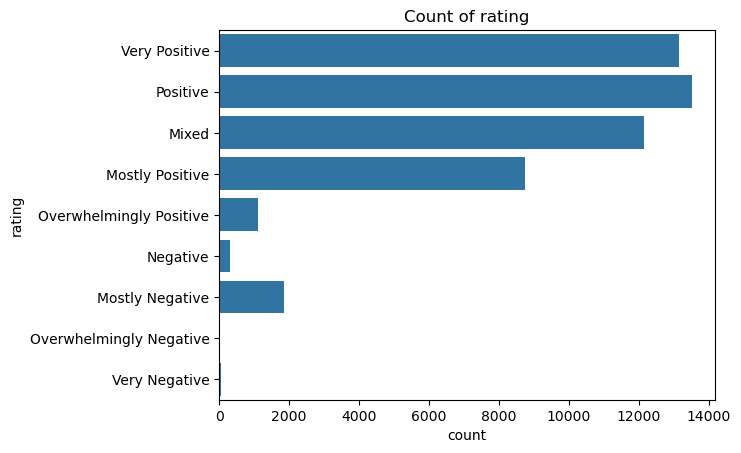

In [41]:
categorical_cols_g = games_df.select_dtypes(include='object').columns
for col in categorical_cols_g:
    print(f"{col} unique values: {games_df[col].nunique()}")
    if games_df[col].nunique() < 20:
        sns.countplot(y=col, data=games_df)
        plt.title(f"Count of {col}")
        plt.show()

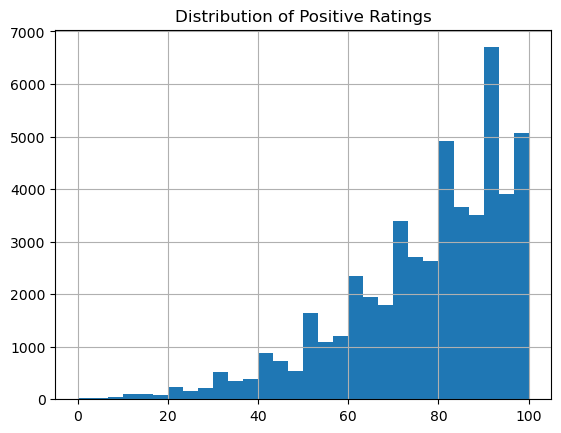

In [42]:
games_df['positive_ratio'].hist(bins=30)
plt.title("Distribution of Positive Ratings")
plt.show()

#### Users dataset

In [43]:
numeric_cols_u = users_df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols_u:
    plt.figure(figsize=(6,4))
    sns.histplot(users_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [44]:
categorical_cols_u = users_df.select_dtypes(include='object').columns
for col in categorical_cols_u:
    print(f"{col} unique values: {users_df[col].nunique()}")
    if users_df[col].nunique() < 20:
        sns.countplot(y=col, data=users_df)
        plt.title(f"Count of {col}")
        plt.show()

#### Recommendations dataset

In [45]:
numeric_cols_r = recommendations_df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols_r:
    plt.figure(figsize=(6,4))
    sns.histplot(recommendations_df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [46]:
categorical_cols_r = recommendations_df.select_dtypes(include='object').columns
for col in categorical_cols_r:
    print(f"{col} unique values: {recommendations_df[col].nunique()}")
    if recommendations_df[col].nunique() < 20:
        sns.countplot(y=col, data=recommendations_df)
        plt.title(f"Count of {col}")
        plt.show()

date unique values: 4450


## Pre-processing
---

## Experiment One - Modeling
---

## Evaulation
---

## Storytelling
---

## Conclusion
---